# Churn Prediction

Churn significa a perda de clientes através do cancelamento.

As empresas de serviços telefônicos, provedores de serviços de Internet, empresas de TV paga, seguradoras e serviços de monitoramento de alarmes costumam usar a análise de churn como uma de suas principais métricas de negócios, porque o custo de reter um cliente existente é muito menor do que adquirir um novo. As empresas desses setores geralmente têm agências de atendimento ao cliente que tentam reconquistar clientes que cancelem, porque os clientes recuperados de longo prazo podem valer muito mais para uma empresa do que os clientes recém-recrutados.

As empresas geralmente fazem uma distinção entre churn voluntário e churn involuntário. O churn voluntário ocorre devido a uma decisão do cliente de mudar para outra empresa ou provedor de serviços, o churn involuntário ocorre devido a circunstâncias como a realocação de um cliente para uma unidade de tratamento prolongado, morte ou a realocação para um local distante. Na maioria das aplicações, razões involuntárias para churn são excluídas dos modelos analíticos. Os analistas tendem a se concentrar no churn voluntário, porque isso geralmente ocorre devido a fatores do relacionamento empresa-cliente que as empresas controlam, como a forma como as interações de cobrança são tratadas ou como a assistência pós-venda é fornecida.

In [1]:
import pandas as pd
import numpy as np
import pickle 
import shap
import time, datetime
import pingouin as pg

from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection, metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import scipy.stats as st
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings("ignore")

The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


In [2]:
# Importa o dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1006,9524-EGPJC,Female,0,No,No,18,Yes,Yes,Fiber optic,No,...,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,90.10,1612.75,Yes
5358,6082-GLJIX,Male,0,No,No,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.25,331.35,No
301,8098-LLAZX,Female,1,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,396.1,Yes


- Customer ID: ID do cliente;
- Gender: Sexo;
- SeniorCitzien: Cliente idoso ou não;
- Partner: Cliente possui um parceiro ou não;
- Tenure: Total de meses ativo;
- PhoneService: Se possui serviço de telefone;
- MultipleLines: Se possui múltiplas linhas ou não;
- InternetService: Tipo de instalação de internet;
- OnlineSecurity: Se possui um serviço de segurança de internet;
- OnlineBackup: Se possui serviço de backup online;
- DeviceProtection: Se possui serviço de proteção dos dispositivos;
- TechSupport: Se possui serviço de suporte técnico;
- StreamingTV: Se possui serviço de streaming de televisão;
- StreamingMovies: Se possui serviço de streaming de filmes;
- Contract: Plano de pagamento;
- PaperlessBilling: Se recebe a fatura impressa;
- PaymentMethod: Método de pagamento;
- MonthlyCharges: Valor da fatura;
- TotalCharges: Total gasto em faturas;
- Churn: Cancelou ou não (target).

In [3]:
# Funções
def countplot(x, y, z):
    print('Variável: ' + x)
    print(data[x].value_counts(normalize = True).round(2))
    print('\n')
    print('Variável: ' + y)
    print(data[y].value_counts(normalize = True).round(2))
    print('\n')
    print('Variável: ' + z)
    print(data[z].value_counts(normalize = True).round(2))
    print('\n')
    
    fig, axs = plt.subplots(ncols = 3, figsize=(20,6))
    sns.countplot(data[x], ax = axs[0], order = data[x].value_counts().index, palette = 'Set1')
    sns.countplot(data[y], ax = axs[1], order = data[y].value_counts().index, palette = 'Set1')
    sns.countplot(data[z], ax = axs[2], order = data[z].value_counts().index, palette = 'Set1')
    
def countplot_2(x, y):
    print('Variável: ' + x)
    print(data[x].value_counts(normalize = True).round(2))
    print('\n')
    print('Variável: ' + y)
    print(data[y].value_counts(normalize = True).round(2))
    print('\n')
    
    fig, axs = plt.subplots(ncols = 2, figsize=(13, 6))
    sns.countplot(data[x], ax = axs[0], order = data[x].value_counts().index, palette = 'Set1')
    sns.countplot(data[y], ax = axs[1], order = data[y].value_counts().index, palette = 'Set1')
    
def countplot_num(x,x1, y,y1, z,z1):
    print('Variável: ' + x)
    print(data[x1].describe())
    print('----------')
    print(data[x].value_counts(normalize = True).round(2))
    print('\n')
    
    print('Variável: ' + y)
    print(data[y1].describe())
    print('----------')
    print(data[y].value_counts(normalize = True).round(2))
    print('\n')
    
    print('Variável: ' + z)
    print(data[z1].describe())
    print('----------')
    print(data[z].value_counts(normalize = True).round(2))
    print('\n')
    
    fig, axs = plt.subplots(ncols = 3, figsize=(25,6))
    sns.countplot(data[x], ax = axs[0], palette = 'Set1')
    sns.countplot(data[y], ax = axs[1], palette = 'Set1')
    sns.countplot(data[z], ax = axs[2], palette = 'Set1')
    
def distplot(x, y, z):
    fig, axs = plt.subplots(ncols = 3, figsize=(25,6))
    sns.distplot(data[x], ax = axs[0])
    sns.distplot(data[y], ax = axs[1])
    sns.distplot(data[z], ax = axs[2])
    
def boxplot(x, y, z):
    fig, axs = plt.subplots(ncols = 3, figsize=(25,6))
    sns.boxplot(data = data, y = x,  ax = axs[0], color = 'skyblue')
    sns.boxplot(data = data, y = y, ax = axs[1], color = 'skyblue')
    sns.boxplot(data = data, y = z, ax = axs[2], color = 'skyblue')
    
def relacao_target(x, y, z):
    print(pd.crosstab(data[x], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    print(pd.crosstab(data[y], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    print(pd.crosstab(data[z], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    fig, axs = plt.subplots(ncols = 3, figsize=(25,6))
    sns.countplot(data = data, x = x, hue = 'Churn', palette = 'Paired', ax = axs[0])
    sns.countplot(data = data, x = y, hue = 'Churn', palette = 'Paired', ax = axs[1])
    sns.countplot(data = data, x = z, hue = 'Churn', palette = 'Paired', ax = axs[2])
    
def relacao_target_2(x, y):
    print(pd.crosstab(data[x], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    print(pd.crosstab(data[y], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    fig, axs = plt.subplots(ncols = 2, figsize=(13,6))
    sns.countplot(data = data, x = x, hue = 'Churn', palette = 'Paired', ax = axs[0])
    sns.countplot(data = data, x = y, hue = 'Churn', palette = 'Paired', ax = axs[1])
    
def relacao_target_num(x,x1, y,y1, z,z1):
    print('Variável: ' + x)
    print(pd.crosstab(data[x1], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    print('Variável: ' + y)
    print(pd.crosstab(data[y1], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')  
    print('Variável: ' + z)
    print(pd.crosstab(data[z1], data['Churn'], normalize = 'index').reset_index().sort_values('Yes', ascending = False))
    print('----------')
    
    fig, axs = plt.subplots(ncols = 3, figsize=(25,6))
    sns.boxplot(data = data, x = 'Churn', y = x, palette = 'Paired', ax = axs[0])
    sns.boxplot(data = data, x = 'Churn', y = y, palette = 'Paired', ax = axs[1])
    sns.boxplot(data = data, x = 'Churn', y = z, palette = 'Paired', ax = axs[2])
    
def corrige_classe(x):
    data[x] = np.where(data[x] == 'No internet service', 'No', data[x])
    
def ajusta_binaria(x):
    data[x] = np.where(data[x] == 'Yes', 1, 0)
    
def treina_testa_modelo(metrica):
    # Testa a performance do modelo base
    # Preparando a lista de modelos
    modelos = []

    modelos.append(('KNeighborsClassifier', KNeighborsClassifier()))
    modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    modelos.append(('RandomForestClassifier', RandomForestClassifier()))
    modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

    # Avaliando cada modelo em um loop
    resultados = []
    nomes = []

    for nome, modelo in modelos:
        kfold = KFold(n_splits = 10, random_state = 1)
        cv_results = cross_val_score(modelo, x, y, cv = kfold, scoring = metrica)
        resultados.append(cv_results)
        nomes.append(nome)
        msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
        print(msg)
        
def treina_testa_modelo_rfe(metrica):
    # Testa a performance do modelo base
    # Preparando a lista de modelos
    modelos = []

    modelos.append(('KNeighborsClassifier', KNeighborsClassifier()))
    modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    modelos.append(('RandomForestClassifier', RandomForestClassifier()))
    modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

    # Avaliando cada modelo em um loop
    resultados = []
    nomes = []

    for nome, modelo in modelos:
        kfold = KFold(n_splits = 10, random_state = 1)
        cv_results = cross_val_score(modelo, x_2, y, cv = kfold, scoring = metrica)
        resultados.append(cv_results)
        nomes.append(nome)
        msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
        print(msg)

# Análise Exploratória e Limpeza de Dados

In [4]:
# Verifica o tipo dos dados
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Verifica se possui dados vazios
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Notamos que os clientes que não possuem internet estão com 'No internet service" preenchido nas variáveis relacionadas aos serviços disponíveis, por conta disso iremos reclassificar os mesmos como 'No'.

In [6]:
corrige_classe('OnlineSecurity')
corrige_classe('OnlineBackup')
corrige_classe('DeviceProtection')
corrige_classe('TechSupport')
corrige_classe('StreamingTV')
corrige_classe('StreamingMovies')

#### O mesmo será realizado com a variável MultipleLines em relação a possuir linha telefônica

In [7]:
data['MultipleLines'] = np.where(data['MultipleLines'] == 'No phone service', 'No', data['MultipleLines'])

#### Para a variável TotalCharges, estamos substituindo os valores faltantes pela multiplicação entre o gasto mensal com o total de meses ativo

In [8]:
# Para a variável Total
data['TotalCharges'] = data["TotalCharges"].replace(" ", np.nan)
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'] * data['tenure']).astype(float)

In [9]:
data['tenure_cat'] = pd.cut(data['tenure'], 6) # Separado com 6 cortes para cada um representar 1 ano
data['MonthlyCharges_cat'] = pd.cut(data['MonthlyCharges'], 5) # Separado com 10 cortes
data['TotalCharges_cat'] = pd.cut(data['TotalCharges'], 5) # Separado com 5 cortes

## Variáveis categóricas

Variável: gender
Male      0.5
Female    0.5
Name: gender, dtype: float64


Variável: SeniorCitizen
0    0.84
1    0.16
Name: SeniorCitizen, dtype: float64


Variável: Partner
No     0.52
Yes    0.48
Name: Partner, dtype: float64




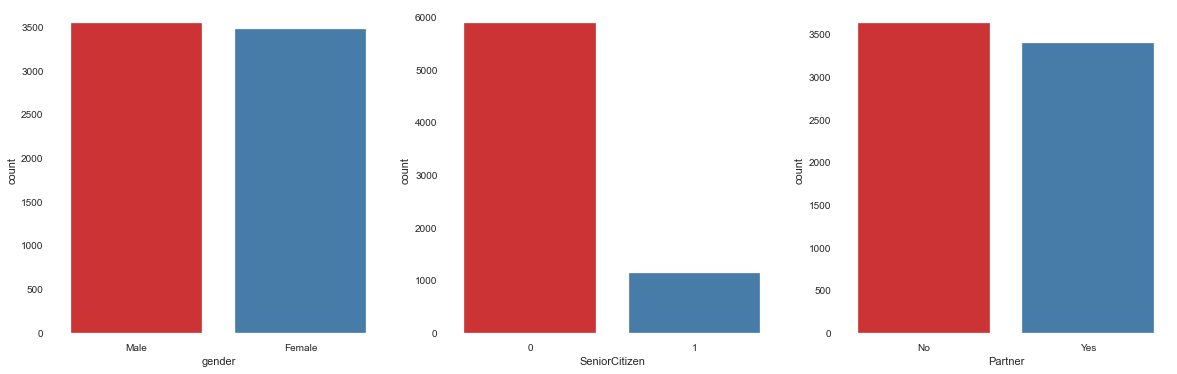

In [10]:
countplot('gender', 'SeniorCitizen', 'Partner')

#### As variáveis de sexo e parceiro são bem equilibradas, com cerca de 50% de representatividade cada, enquanto os idosos representam cerca de 16% da base total.

Variável: Dependents
No     0.7
Yes    0.3
Name: Dependents, dtype: float64


Variável: PhoneService
Yes    0.9
No     0.1
Name: PhoneService, dtype: float64


Variável: MultipleLines
No     0.58
Yes    0.42
Name: MultipleLines, dtype: float64




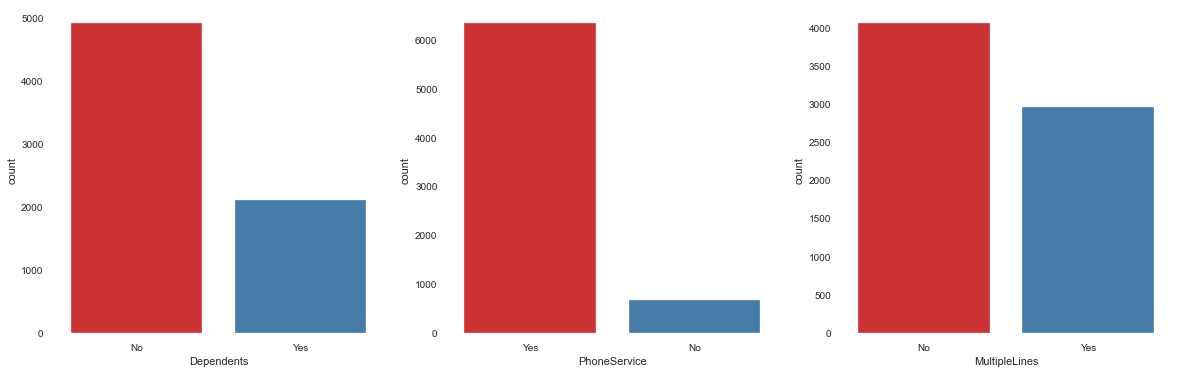

In [11]:
countplot('Dependents', 'PhoneService', 'MultipleLines')

#### 30% da base possui dependentes, enquanto 90% possui algum serviço de telefone atrelado, e, dentre eles, a relação entre multiplas linhas é bem equilibrada, com 42% possuindo multiplas linhas e 58% não possuindo.

Variável: InternetService
Fiber optic    0.44
DSL            0.34
No             0.22
Name: InternetService, dtype: float64


Variável: OnlineSecurity
No     0.71
Yes    0.29
Name: OnlineSecurity, dtype: float64


Variável: OnlineBackup
No     0.66
Yes    0.34
Name: OnlineBackup, dtype: float64




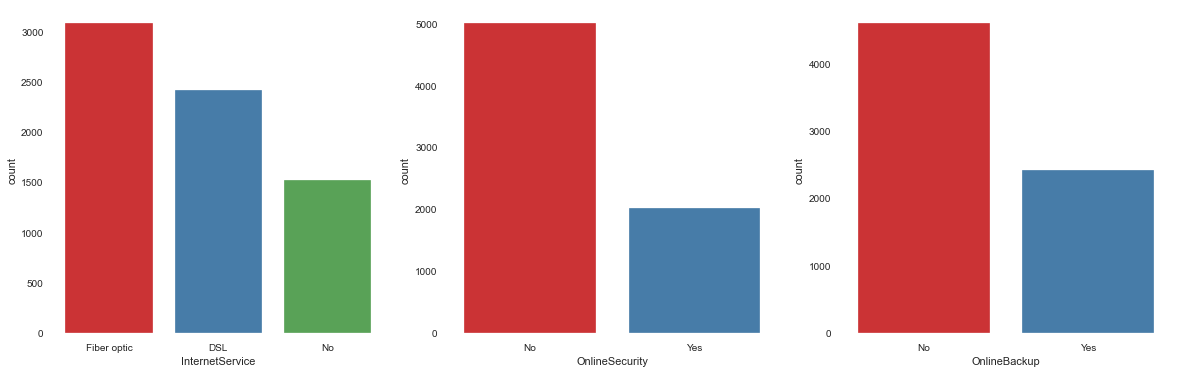

In [12]:
countplot('InternetService', 'OnlineSecurity', 'OnlineBackup')

#### Em relação ao serviço de internet, 44% possuem fibra ótica, enquanto 34% possuem rede dsl e 22% não possuem internet, e, em relação ao serviço de segurança online, 29% possuem enquanto 71% não possuem, enquanto isso, o backup em nuvem cativa 34% dos clientes que possuem internet, contra 66% que não utilizam.

Variável: DeviceProtection
No     0.66
Yes    0.34
Name: DeviceProtection, dtype: float64


Variável: TechSupport
No     0.71
Yes    0.29
Name: TechSupport, dtype: float64




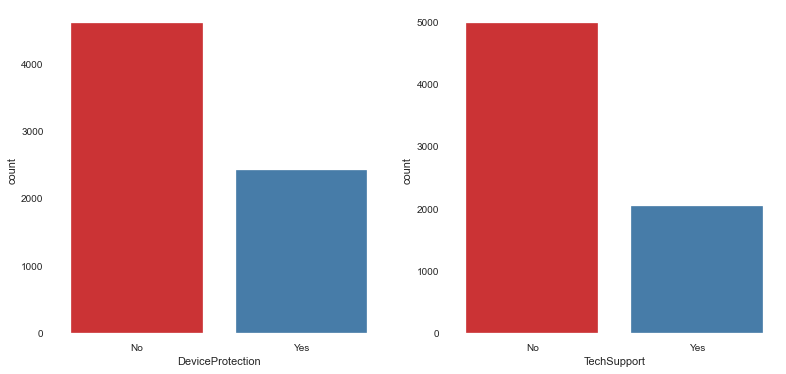

In [13]:
countplot_2('DeviceProtection', 'TechSupport')

#### Falando em proteção de dispositivo e suporte técnico, a representatividade de clientes que utilizam os serviços são de 34% e 29% respectivamente.

Variável: StreamingTV
No     0.62
Yes    0.38
Name: StreamingTV, dtype: float64


Variável: StreamingMovies
No     0.61
Yes    0.39
Name: StreamingMovies, dtype: float64




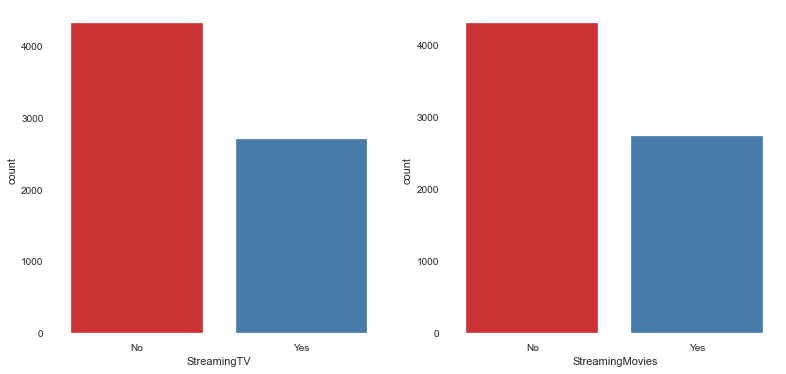

In [14]:
countplot_2('StreamingTV', 'StreamingMovies')

#### Os serviços de streaming são os serviços com maior adesão por parte dos clientes, com 38% utilizando TV e 39% utilizando streaming de filmes.

Variável: Contract
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: Contract, dtype: float64


Variável: PaperlessBilling
Yes    0.59
No     0.41
Name: PaperlessBilling, dtype: float64


Variável: PaymentMethod
Electronic check             0.34
Mailed check                 0.23
Bank transfer (automatic)    0.22
Credit card (automatic)      0.22
Name: PaymentMethod, dtype: float64




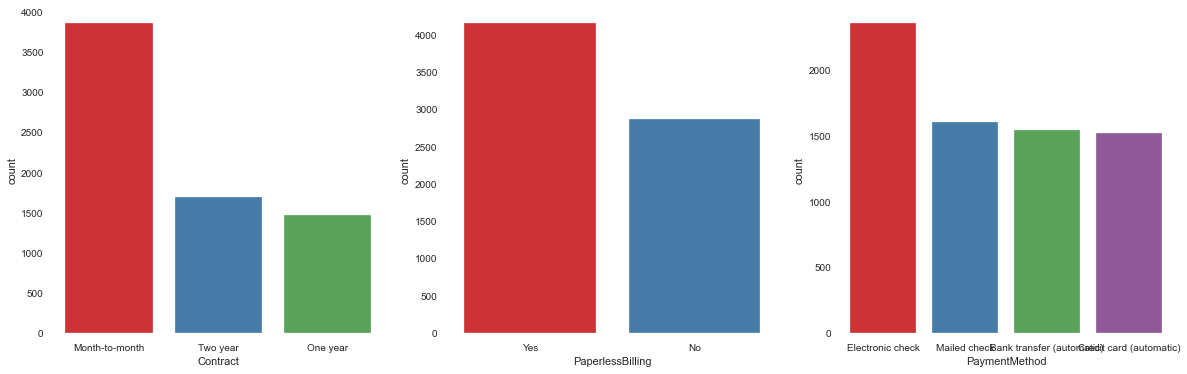

In [15]:
countplot('Contract', 'PaperlessBilling', 'PaymentMethod')

#### Quanto falamos em planos de pagamento, 55% da base possui um plano mensal, 59% recebem fatura em papel e 34% pagam seu plano utilizando cheque eletrônico.

No     0.73
Yes    0.27
Name: Churn, dtype: float64




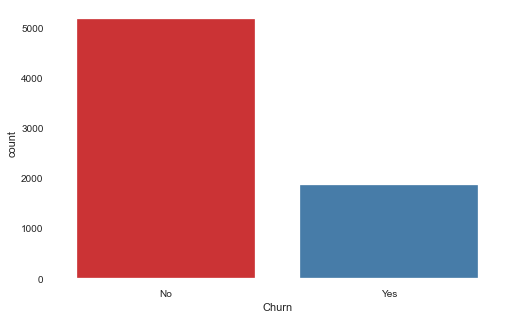

In [16]:
print(data['Churn'].value_counts(normalize = True).round(2))
print('\n')
plt.figure(figsize = (8, 5))
sns.countplot(data['Churn'], palette = 'Set1')

#### Analisando a distribuição de nossa variável target, possuimos 30% da base com Churn = 1, não considero este valor tão desbalanceado a ponto de possuir a necessidade de realizar um processo de under ou oversample, por conta disso, a variável não será transformada.

## Numéricas

Variável: tenure_cat
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
----------
(-0.072, 12.0]    0.31
(60.0, 72.0]      0.20
(12.0, 24.0]      0.15
(48.0, 60.0]      0.12
(24.0, 36.0]      0.12
(36.0, 48.0]      0.11
Name: tenure_cat, dtype: float64


Variável: MonthlyCharges_cat
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64
----------
(78.55, 98.65]     0.26
(18.15, 38.35]     0.26
(58.45, 78.55]     0.19
(98.65, 118.75]    0.15
(38.35, 58.45]     0.14
Name: MonthlyCharges_cat, dtype: float64


Variável: TotalCharges_cat
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.80

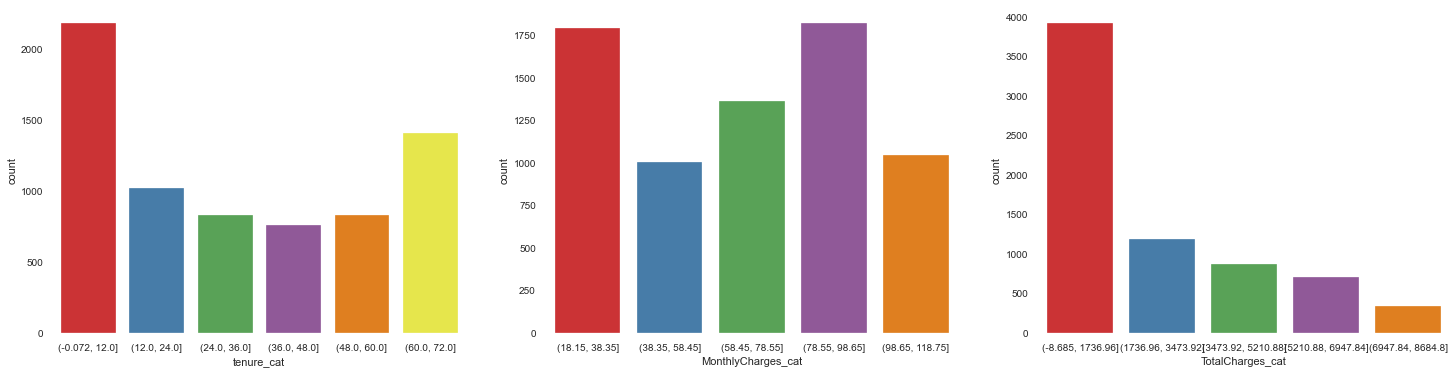

In [17]:
countplot_num('tenure_cat','tenure',  'MonthlyCharges_cat','MonthlyCharges', 'TotalCharges_cat', 'TotalCharges')

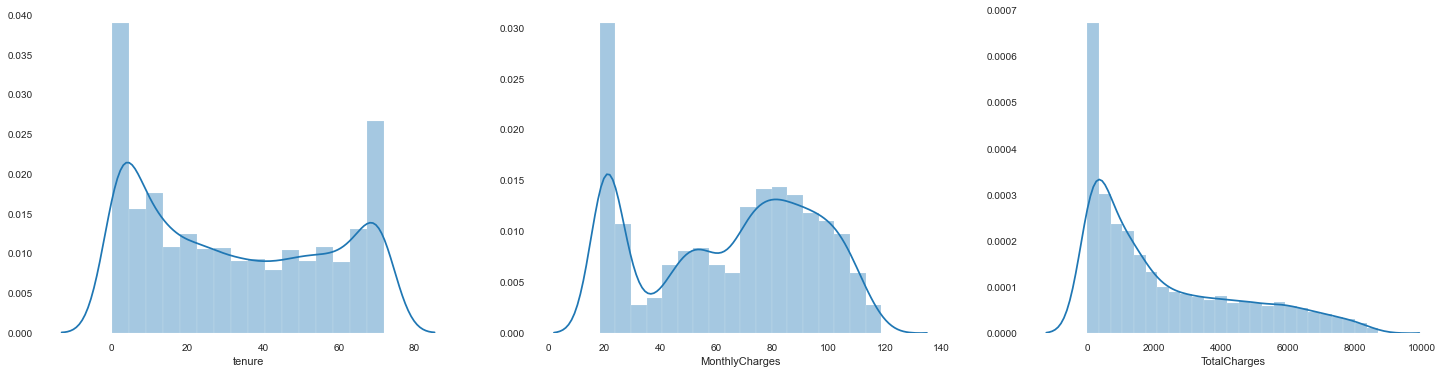

In [18]:
distplot('tenure', 'MonthlyCharges', 'TotalCharges')

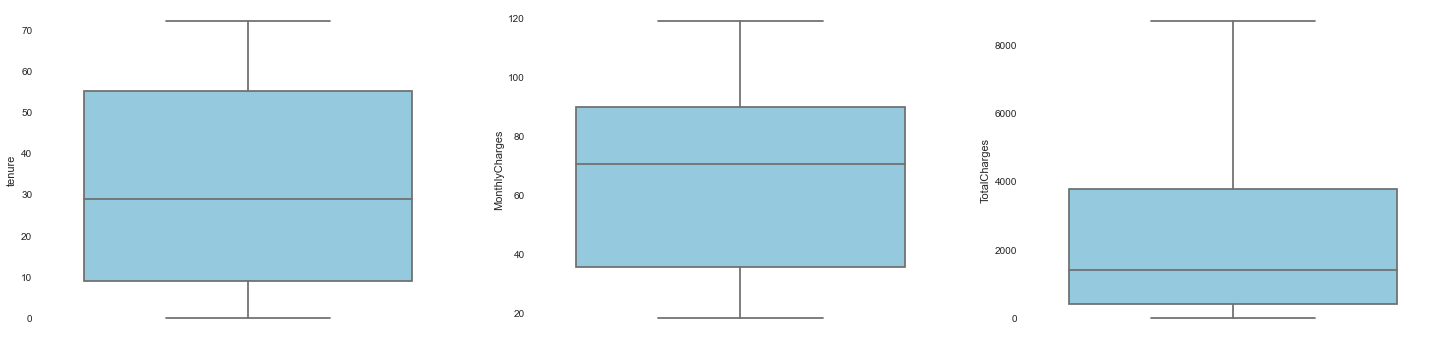

In [19]:
boxplot('tenure', 'MonthlyCharges', 'TotalCharges')

#### - Tenure: Os clientes estão ativos na base em média há 2.5 anos, com o cliente mais novo há menos de 1 ano e o mais velho há 6 anos. A distribuição conta com 51% dos clientes ativos a menos de 1 ano ou a mais de 6 anos, enquanto as faixas de 1 a 6 anos possuem em média 12,5% de representatividade cada.
#### - MonthlyCharges: Os clientes possuem um custo médio de fatura de 64, com a fatura mais barato sendo 15,25 e a mais cara 118,75. As distribuições com maior representatividade custam de 18,15 a 38,35 e 75,55 a 98,65 com 26% de representatividade cada, enquanto as demais possuem em média 16% de representatividade cada.
#### - TotalCharges: Os clientes possuem um custo médio do total gasto 2.279, com o cliente que menos gastou com 0 (não completou 1 mês) e o que mais gastou com 8.864. A distribuiçõe com maior representatividade é a de gastos até 1.7 mil, com 51%.

###### obs: não foram encontrados outliers

# Relação com Target

Churn  gender        No       Yes
0      Female  0.730791  0.269209
1        Male  0.738397  0.261603
----------
Churn  SeniorCitizen        No       Yes
1                  1  0.583187  0.416813
0                  0  0.763938  0.236062
----------
Churn Partner        No       Yes
0          No  0.670420  0.329580
1         Yes  0.803351  0.196649
----------


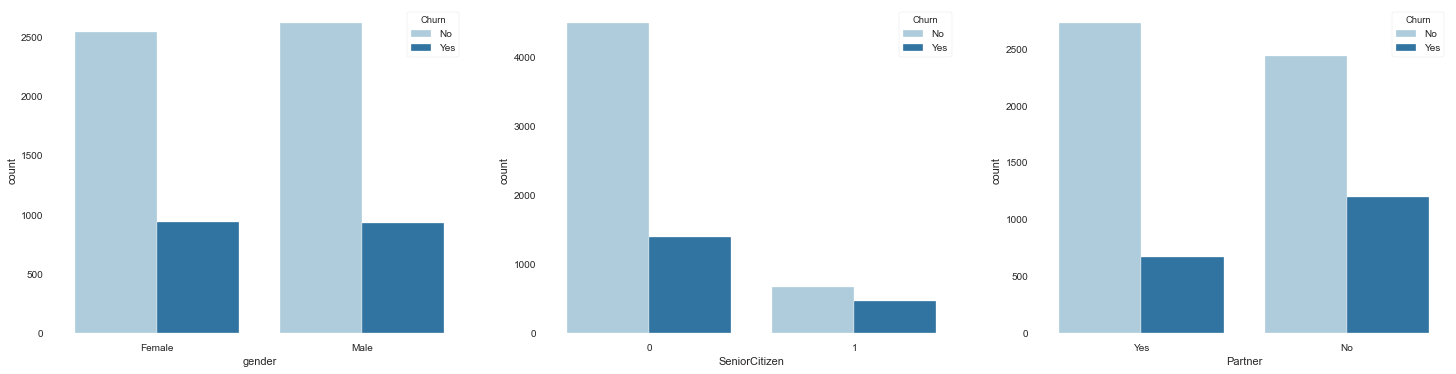

In [20]:
relacao_target('gender', 'SeniorCitizen', 'Partner')

#### A variável de sexo se manteve bem equilibrada, com as duas classes com 26% de relação ao churn, enquanto isso, os idosos e clientes que não possuem parceiros apresentam uma relação maior com o churn.

Churn Dependents        No       Yes
0             No  0.687209  0.312791
1            Yes  0.845498  0.154502
----------
Churn PhoneService        No       Yes
1              Yes  0.732904  0.267096
0               No  0.750733  0.249267
----------
Churn MultipleLines        No       Yes
1               Yes  0.713901  0.286099
0                No  0.749754  0.250246
----------


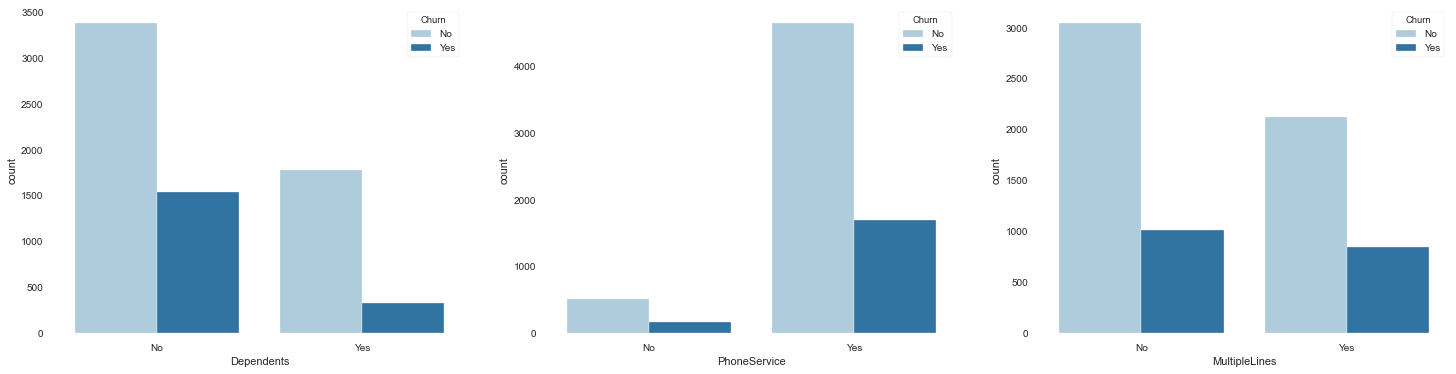

In [21]:
relacao_target('Dependents', 'PhoneService', 'MultipleLines')

#### As variáveis de Dependetes = Sim possue uma baixa relação com o churn, o que nos indica que clientes que possuem dependentes tendem a cancelar menos, enquanto as outras duas variáveis analisadas possuem comportamentos equilibrados

Churn InternetService        No       Yes
1         Fiber optic  0.581072  0.418928
0                 DSL  0.810409  0.189591
2                  No  0.925950  0.074050
----------
Churn OnlineSecurity        No       Yes
0                 No  0.686704  0.313296
1                Yes  0.853888  0.146112
----------
Churn OnlineBackup        No       Yes
0               No  0.708279  0.291721
1              Yes  0.784685  0.215315
----------


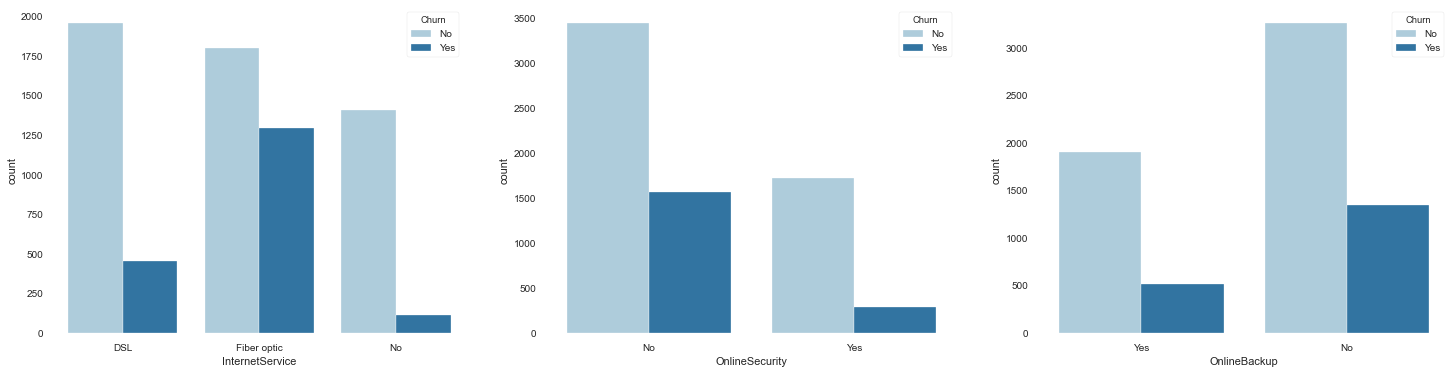

In [22]:
relacao_target('InternetService', 'OnlineSecurity', 'OnlineBackup')

#### A variável de tipo de serviço de internet também possui uma grande tendência ao churn para os clientes que utilizam fibra ótica, o mesmo ocorre com quem não utiliza serviços de segurança online. Enquanto isso, o fato de utilizar ou não backup na nuvem não indica relação com o cancelamento.

Churn DeviceProtection        No       Yes
0                   No  0.713482  0.286518
1                  Yes  0.774979  0.225021
----------
Churn TechSupport        No       Yes
0              No  0.688138  0.311862
1             Yes  0.848337  0.151663
----------
Churn        Contract        No       Yes
0      Month-to-month  0.572903  0.427097
1            One year  0.887305  0.112695
2            Two year  0.971681  0.028319
----------


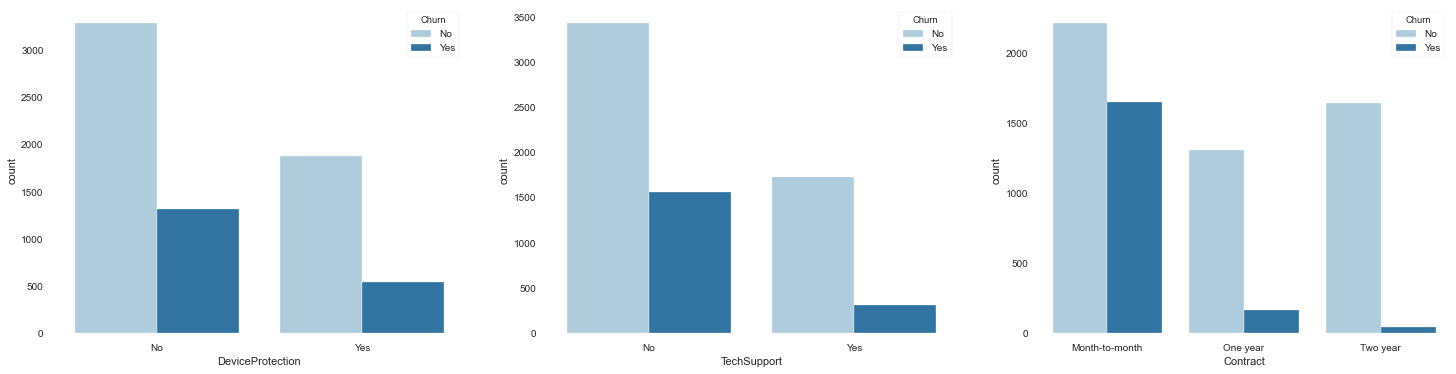

In [23]:
relacao_target('DeviceProtection', 'TechSupport', 'Contract')

#### Duas variáveis com clara tendência ao churn: Contrato Mensal e Nao utilizar suporte tecnico. No caso do tipo de contrato, essa informação está ainda mais nítida, com 42% de relação ao target para mensais, 11% para os anuais e apenas 2% para contratos de 2 anos.

Churn StreamingTV        No       Yes
1             Yes  0.699298  0.300702
0              No  0.756688  0.243312
----------
Churn StreamingMovies        No       Yes
1                 Yes  0.700586  0.299414
0                  No  0.756205  0.243795
----------


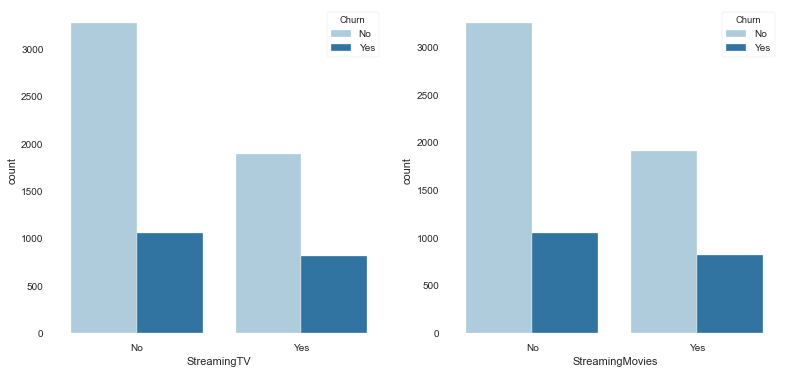

In [24]:
relacao_target_2('StreamingTV', 'StreamingMovies')

#### As duas variáveis relacionadas ao streaming são bem equilibradas, não apresentando tendências.

Churn PaperlessBilling        No       Yes
1                  Yes  0.664349  0.335651
0                   No  0.836699  0.163301
----------
Churn              PaymentMethod        No       Yes
2               Electronic check  0.547146  0.452854
3                   Mailed check  0.808933  0.191067
0      Bank transfer (automatic)  0.832902  0.167098
1        Credit card (automatic)  0.847569  0.152431
----------


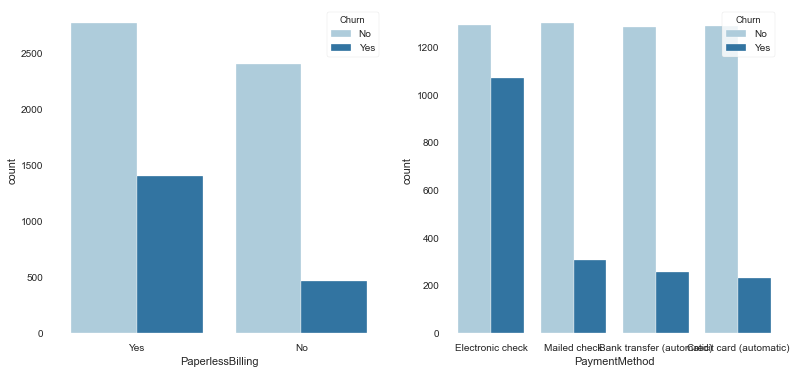

In [25]:
relacao_target_2('PaperlessBilling', 'PaymentMethod')

#### Mais duas variáveis com alta tendência ao churn: Receber faturas em papel e realizar o pagamento com cheque eletrônico, variável inclusive com uma tendência 2x maior que as demais formas de pagamento disponíveis. O que é bem preocupante no caso, uma vez que o pagamento com cheque eletrônico representa 34% de toda a base.

Variável: tenure
Churn      tenure_cat        No       Yes
0      (-0.072, 12.0]  0.525618  0.474382
1        (12.0, 24.0]  0.712891  0.287109
2        (24.0, 36.0]  0.783654  0.216346
3        (36.0, 48.0]  0.809711  0.190289
4        (48.0, 60.0]  0.855769  0.144231
5        (60.0, 72.0]  0.933902  0.066098
----------
Variável: MonthlyCharges
Churn MonthlyCharges_cat        No       Yes
3         (78.55, 98.65]  0.630340  0.369660
4        (98.65, 118.75]  0.699427  0.300573
2         (58.45, 78.55]  0.705194  0.294806
1         (38.35, 58.45]  0.730348  0.269652
0         (18.15, 38.35]  0.885921  0.114079
----------
Variável: TotalCharges
Churn    TotalCharges_cat        No       Yes
0       (-8.685, 1736.96]  0.671589  0.328411
1      (1736.96, 3473.92]  0.754209  0.245791
2      (3473.92, 5210.88]  0.832952  0.167048
3      (5210.88, 6947.84]  0.852900  0.147100
4       (6947.84, 8684.8]  0.893064  0.106936
----------


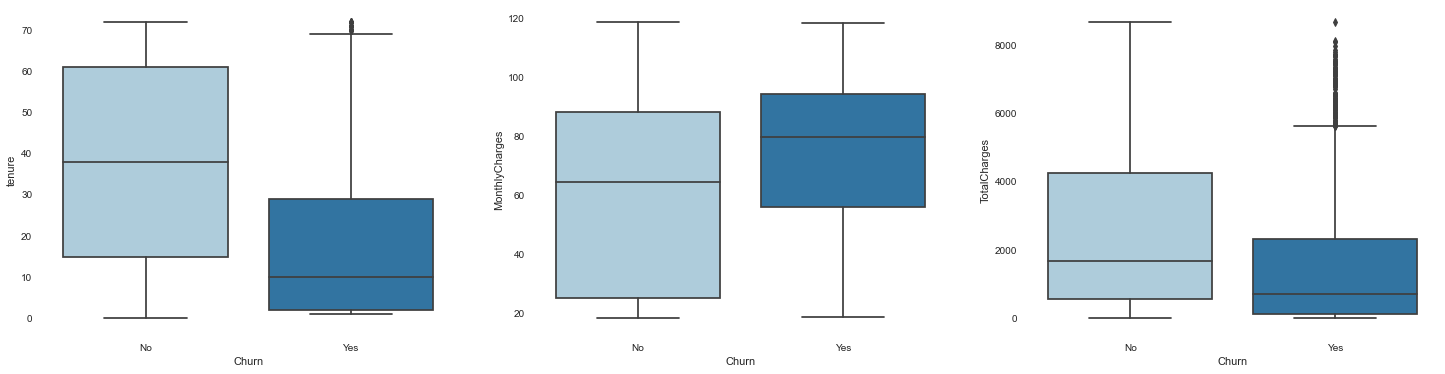

In [26]:
relacao_target_num('tenure','tenure_cat', 'MonthlyCharges','MonthlyCharges_cat', 'TotalCharges','TotalCharges_cat')

#### Podemos observar claramente que os clientes com menor tempo de casa possuem uma tendência maior ao cancelamento, assim como os clientes que possuem as faturas mais caras. Isso nos indica claramente a falta de fidelidade dos clientes na marca e um enorme prejuízo na conta, pois conseguir novo clientes é bem mais custoso do que reter os existentes, havendo assim a necessidade de melhorias nos planos de retenção.

# Modelagem Preditiva

#### Para as variáveis binárias iremos apenas converter em 1 para Yes e 0 para No, para as demais categóricas, transformaremos em dummy

In [27]:
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)
ajusta_binaria('Partner')
ajusta_binaria('Dependents')
ajusta_binaria('PhoneService')
ajusta_binaria('MultipleLines')
ajusta_binaria('OnlineSecurity')
ajusta_binaria('OnlineBackup')
ajusta_binaria('DeviceProtection')
ajusta_binaria('TechSupport')
ajusta_binaria('StreamingTV')
ajusta_binaria('StreamingMovies')
ajusta_binaria('PaperlessBilling')
ajusta_binaria('Churn')

In [28]:
# Deletando as categoricas criadas para análise gráfica
del data['tenure_cat']
del data['MonthlyCharges_cat']
del data['TotalCharges_cat']
del data['TotalCharges']
del data['customerID']

#### Além de deletar as variáveis numéricas que categorizamos para exploração, deletei também a variável de Total Charges, pois entendo que ela possui a mesma informação da MonthlyCharge * Tenure.

In [29]:
data.dtypes

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService      object
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract             object
PaperlessBilling      int32
PaymentMethod        object
MonthlyCharges      float64
Churn                 int32
dtype: object

In [31]:
# Separa as variáveis preditoras e target
x = data.iloc[:, 0:17]
y = data.iloc[:, 18]

In [32]:
# Cria variáveis dummy
x = pd.get_dummies(x)

-----------------
# RFE para seleção de variáveis

Para realizar a seleção das features, utilizamos uma técnica chamada RFE (Recursive Feature Elimiation) que basicamente é uma seleção retroativa dos preditores. Essa técnica começa construindo um modelo em todo o conjunto de preditores e calcula uma pontuação de importância para cada preditor. Os preditores menos importantes são removidos, o modelo é reconstruído e as pontuações de importância são computadas novamente. Portanto, o tamanho do subconjunto é o parâmetro de ajuste para o RFE e otimiza os critérios de desempenho usados para selecionar os preditores com base nas classificações de importância.

--------------------

Feature Ranking For Non-Discretised: [1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 23


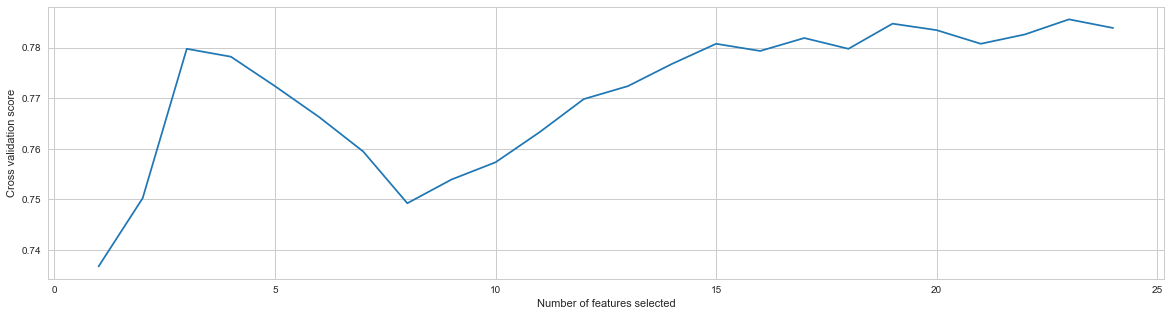

In [41]:
# Calcular o RFE para o conjunto de dados e representar graficamente a importância de cada recurso
selector1 = RFECV(RandomForestClassifier(), step = 1, cv = 10, n_jobs=-1)
selector1 = selector1.fit(x, y)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);

In [42]:
testa = pd.DataFrame(x.columns[0:60]).reset_index()
testa2 = pd.DataFrame(selector1.ranking_).reset_index()
features = pd.merge(testa, testa2, on = 'index', how = 'left').rename(columns = {'0_x': 'Feature', 
                                                                                 '0_y': 'Ranking'})

features = features[features['Ranking'] == 1]
features = features['Feature'].tolist()
features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

#### Nosso algoritmo de RFE selecionou que devemos utilizar 23 variáveis para termos o melhor resultado

In [43]:
# Separa o treino utilizando apenas as variáveis selecionadas
x_2 = x[features]

Algortimos que serão testados:

- KNN
- Random Forest
- Decision Tree
- Gradient Boosted Trees

#### Primeiro iremos realizar um teste geral utilizando todos os modelos e as métricas F1-Score e ROC_AUC, para após isso, otimizarmos o modelo com a melhor performance:

In [44]:
treina_testa_modelo('f1')

KNeighborsClassifier: 0.541048 (0.015802)
DecisionTreeClassifier: 0.502404 (0.026683)
RandomForestClassifier: 0.546697 (0.019841)
GradientBoostingClassifier: 0.591155 (0.021013)


In [45]:
treina_testa_modelo('roc_auc')

KNeighborsClassifier: 0.785471 (0.011778)
DecisionTreeClassifier: 0.671989 (0.019917)
RandomForestClassifier: 0.812566 (0.016440)
GradientBoostingClassifier: 0.849019 (0.012746)


#### Agora realizaremos os mesmos teste utilizando apenas as variáveis selecionadas no RFE:

In [46]:
treina_testa_modelo_rfe('f1')

KNeighborsClassifier: 0.547265 (0.022543)
DecisionTreeClassifier: 0.498673 (0.021078)
RandomForestClassifier: 0.543934 (0.023189)
GradientBoostingClassifier: 0.587874 (0.018121)


In [47]:
treina_testa_modelo_rfe('roc_auc')

KNeighborsClassifier: 0.787203 (0.015833)
DecisionTreeClassifier: 0.670401 (0.017665)
RandomForestClassifier: 0.813006 (0.017123)
GradientBoostingClassifier: 0.848534 (0.013040)


-----------
#### Como podemos observar, os resultados não foram tão diferentes entre o modelo com todas as features e com o RFE, com isso, utilizaremos o modelo com RFE por conta da redução de variáveis, facilitando assim sua interpretação. E, a melhor classificação foi o Gradient Boosting, realizaremos o Hyperparameter tunning e a extração das Feature Importances e SHAP Values
-----------

In [48]:
# Separação entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_2, y, test_size = 0.25, random_state = 1)

# Cria um dicionário com os hyperparâmetros e modelos que serão testados;
search_space = [{"n_estimators": [5, 10, 100, 500, 1000],
                "max_depth":[5, 8, 15, 25, 30, 50, 100, None],
                "min_samples_leaf":[1, 2, 5, 10, 15, 30, 50, 100], 
                "max_leaf_nodes": [2, 5, 10, 15, 30]
                 }] 

modelo = GradientBoostingClassifier()

# Cria o tunner
rsearch = RandomizedSearchCV(estimator = modelo,
                            param_distributions = search_space,
                            n_iter = 10,
                            random_state = 1)

best_model = rsearch.fit(x_2, y)

print(best_model.best_estimator_)

GradientBoostingClassifier(max_depth=30, max_leaf_nodes=5, min_samples_leaf=2)


-----------------------------------------------------------------------------------
### Para avaliação do modelo utilizamos a curva ROC, que nos mostra o quão bom o modelo criado pode distinguir entre duas classes. 

O ROC possui dois parâmetros:
- Taxa de verdadeiro positivo (True Positive Rate), que é dado por true positives / (true positives + false negatives)
- Taxa de falso positivo (False Positive Rate), que é dado por false positives / (false positives + true negatives)

Uma curva ROC traça “True Positive Rate vs. False Positive Rate” em diferentes limiares de classificação (figura ao lado).

Assim, na tentativa de simplificar a análise da ROC, a AUC (“area under the ROC curve”) nada mais é que uma maneira de resumir a curva ROC em um único valor, agregando todos os limiares da ROC, calculando a “área sob a curva”.

-----------------------------------------------------------------------------------
Além da ROC_AUC, utilizaremos mais 3 métricas de avaliação:

    - Precision: Verdadeiro Positivo / Verdadeiros Positivos + Falsos Positivos
      Daqueles que classifiquei como corretos, quantos efetivamente eram?
      
    - Recall: Verdadeiro Positivo / Verdadeiros Positivos + Falsos Negativo
      Quando realmente é da classe X, o quão frequente classifiquei como X?
      
    - F1: 2 * Precision * Recall / Precision + Recall
      Essa métrica combina Precision e Recall, de modo a trazer um número único que indique a qualidade geral do seu modelo
------------------

In [49]:
# Cria o modelo com os parâmetros definidos pelo hyperparameter tunning e testa com cross-validation
modelo = GradientBoostingClassifier(max_depth = 30, 
                                    max_leaf_nodes = 5, 
                                    min_samples_leaf = 2).fit(x_train, y_train)
y_pred = modelo.predict(x_test)
y_proba = modelo.predict_proba(x_test)[::,1]


print(classification_report(y_test, y_pred, target_names = ['No', 'Yes']))
print('\n')

roc_auc = cross_val_score(modelo, x_test, y_test, cv = 10, scoring = 'roc_auc')
print('Lista CV - ROC_AUC: ' + str(roc_auc.round(2)))
print('Média - ROC_AUC: '+ str(roc_auc.mean().round(2)))
print('\n')
f1 = cross_val_score(modelo, x_test, y_test, cv = 10, scoring = 'f1')
print('Lista CV - F1: ' + str(f1.round(2)))
print('Média - F1: '+ str(f1.mean().round(2)))

              precision    recall  f1-score   support

          No       0.86      0.89      0.88      1327
         Yes       0.62      0.56      0.59       434

    accuracy                           0.81      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.80      0.81      0.80      1761



Lista CV - ROC_AUC: [0.86 0.87 0.81 0.79 0.89 0.89 0.86 0.83 0.81 0.9 ]
Média - ROC_AUC: 0.85


Lista CV - F1: [0.58 0.66 0.45 0.51 0.7  0.66 0.56 0.55 0.43 0.6 ]
Média - F1: 0.57


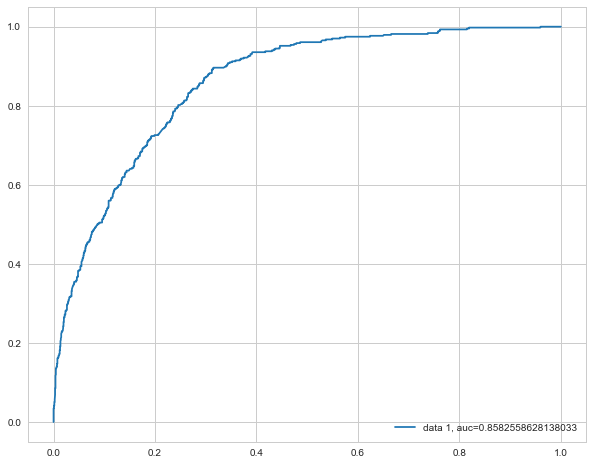

In [50]:
# Print da curva AUC
fpr, tpr, _ = roc_curve(y_test,  y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize = (10, 8))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

----------------
#### Com a otimização dos hyperparâmetros ganhamos 1% de F1 score e ganhamos 1% de ROC_AUC em relação ao modelo base e ao modelo com RFE.
----------------

# Feature Importance

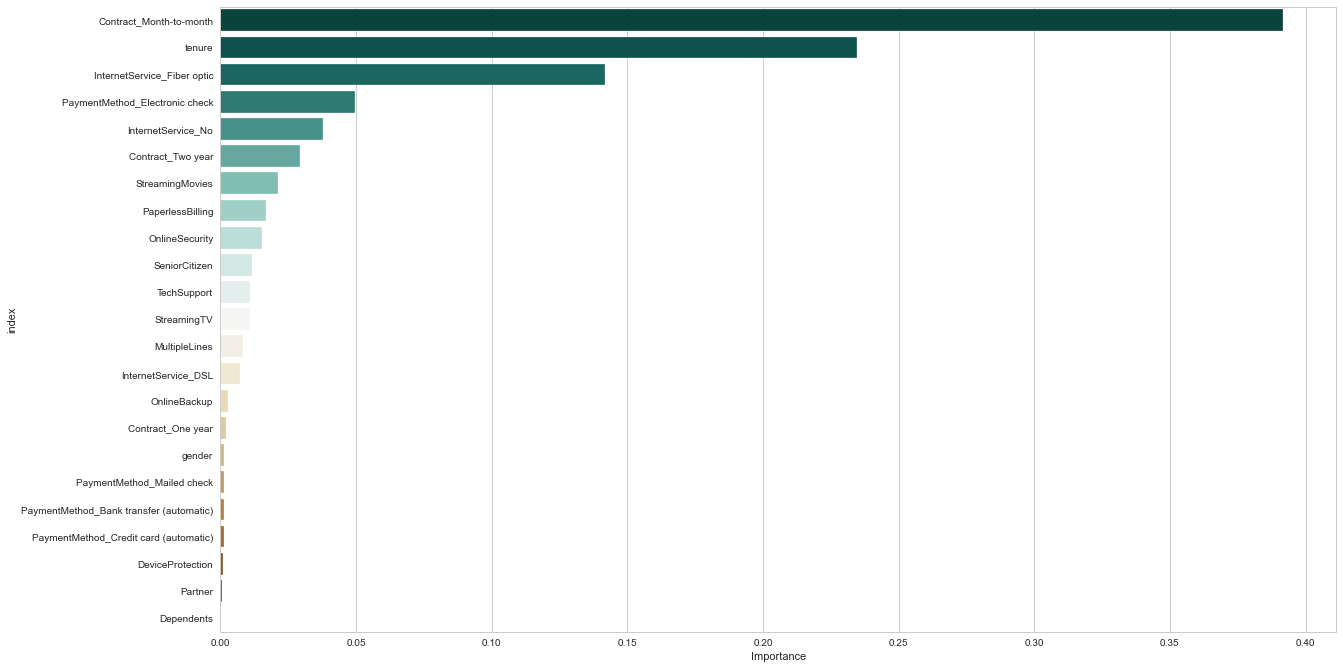

In [51]:
# Extração das features importances
plt.style.use('seaborn-whitegrid')
importance = modelo.feature_importances_
importance = pd.DataFrame(importance, index = x_train.columns, columns=["Importance"]).reset_index().sort_values('Importance', ascending = False)
plt.figure(figsize=(20,len(importance)/2))
sns.barplot(data = importance, x = 'Importance', y = 'index', palette = 'BrBG_r')

-------------------
#### - As 5 variáveis com maior importância foram as relativas a forma mensal de pagamento, tempo ativo na empresa, possuir fibra ótica, pagamento com cheque eletrônico e não possuir serviços de internet, o que não nos surpreende, uma vez que na análise exploratória já foram detectadas como variáveis desbalanceadas, com uma clara tendência ao churn dadas essas características.
-------------------

# SHAP Values

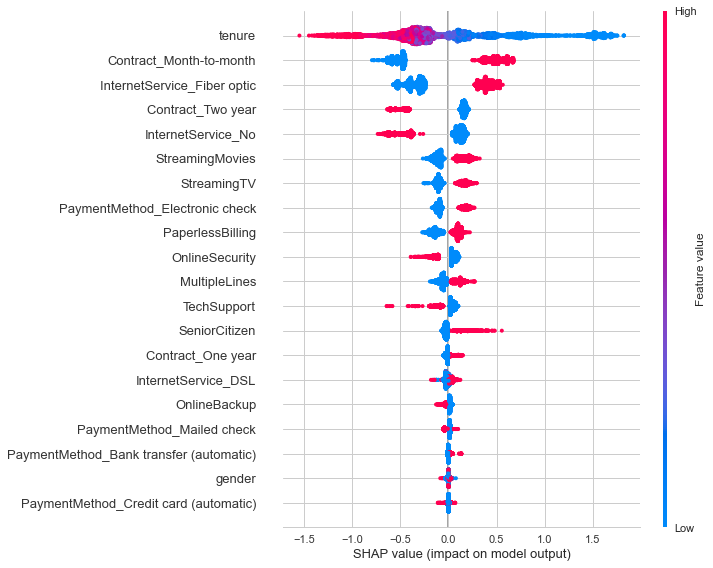

In [52]:
# Rotula a base
X = pd.DataFrame(x_train)
X.columns = x_train.columns

# Cria o explainer
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

-----------------
Com o SHAP podemos ver quanto cada variável contribuiu para o resultado final da predição:
- Quanto maior o valor da variável, maior a intensidade da cor vermelha;
- Quanto menor o valor da variável, maior a intensidade da cor azul;
- Quanto mais pra direita o dado se encontra, maior a força da predição para ocorrer o churn.

obs: em caso de variável categórica, 1 é vermelho e 0 é azul.

-----------------

# Salva o artefato do modelo

In [53]:
filename = 'churn_prediction.sav'
pickle.dump(modelo, open(filename, 'wb'))